In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../") 

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
import numpy as np
from PIL import Image
import json
import os
import torch
import pickle
from autoaugment import CIFAR10Policy


In [3]:
from warnings import filterwarnings

filterwarnings("ignore")

import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import random
import os

import numpy as np
from PreResNet import *
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import dataloader_cifar as dataloader
import pickle
from torch.utils.data import Dataset, DataLoader
import argparse
import json
import os

import tqdm.notebook as tqdm


In [4]:
machine  = 'yi'
def parse_args(file):
#     parser = argparse.ArgumentParser(description="PyTorch CIFAR Training")
#     parser.add_argument("--preset", required=True, type=str)
#     parser.add_argument("--machine", required=False, type=str, default="")
#     cmdline_args = parser.parse_args()

    

    with open(file, "r") as f:
        jsonFile = json.load(f)

    class dotdict(dict):
        def __getattr__(self, name):
            return self[name]

        def __setattr__(self, name, value):
            self[name] = value

    args = dotdict()
    args.update(jsonFile)
    if "machines" in jsonFile and machine in jsonFile["machines"]:
        args.update(jsonFile["machines"][machine])
    if "configs" in args:
        del args["configs"]
        jsonFile = jsonFile["configs"]

    args.preset = preset
    subpresets = preset.split(".")
    for subp in subpresets:
        jsonFile = jsonFile[subp]
        args.update(jsonFile)
        if "configs" in args:
            del args["configs"]
        if "machines" in args:
            if machine != "":
                args.update(jsonFile["machines"][machine])
            del args["machines"]
        if "configs" in jsonFile:
            jsonFile = jsonFile["configs"]

    args.checkpoint_path += "/" + "/".join(args.preset.split("."))
    args.pretrained_path = args.checkpoint_path

    if not os.path.exists(args.checkpoint_path):
        os.makedirs(args.checkpoint_path)
    all_folder = os.path.join(args.checkpoint_path, "all")
    if not os.path.exists(all_folder):
        os.mkdir(all_folder)
    saved_folder = os.path.join(args.checkpoint_path, "saved")
    if not os.path.exists(saved_folder):
        os.mkdir(saved_folder)
    if not os.path.exists(args.pretrained_path + f"/saved/{args.preset}.pkl"):
        args.pretrained_path = ""

    with open(args.checkpoint_path + "/saved/info.json", "w") as f:
        json.dump(args, f, indent=4, sort_keys=True)

    return args


In [5]:
plain_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
            ),
        ]
    )


def unpickle(file):
    import _pickle as cPickle

    with open(file, "rb") as fo:
        dict = cPickle.load(fo, encoding="latin1")
    return dict


class PlainDataset(Dataset):
    def __init__(self, ds, clean_labels, dirty_labels):
        
        self.ds = ds
        
        self.clean_labels = clean_labels
        self.dirty_labels = dirty_labels
    
    def __getitem__(self, idx):
        img = self.ds[idx]
        tgt = self.clean_labels[idx]
        img = plain_transform(img)
        
        return img, tgt
    
    def __len__(self):
        if len(self.ds) != len(self.clean_labels) or len(self.ds) != len(self.dirty_labels):
            print("ERROR")
        return len(self.ds)
        
        
class SemiLoss(object):
    def __call__(self, outputs_x_1, targets_x, outputs_u, targets_u, epoch, warm_up):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(
            torch.sum(F.log_softmax(outputs_x_1, dim=1) * targets_x, dim=1)
        )
        Lu = torch.mean((probs_u - targets_u) ** 2)

        return Lx, Lu, linear_rampup(epoch, warm_up)


def get_dataloaders(preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.25', machine = 'yi'):
    
    args = parse_args("../presets.json")
    
    root_dir = args.data_path
    print(root_dir)
    loader = dataloader.cifar_dataloader(
        dataset=args.dataset,
        r=args.r,
        noise_mode=args.noise_mode,
        batch_size=args.batch_size,
        warmup_batch_size=args.warmup_batch_size,
        num_workers=args.num_workers,
        root_dir=args.data_path,
        noise_file="%s/saved/%.1f_%s.json"
        % (args.checkpoint_path, args.r, args.noise_mode),
        preaug_file="",#(
            #("%s/saved/data_%s.pkl" % (args.checkpoint_path, args.preset))
            #""
            #if args.preaugment_transform
            #else ""
        #),
        augmentation_strategy=args,
    )

    train_data = []
    train_label = []
    for n in range(1, 6):
        dpath = "%s/data_batch_%d" % (root_dir, n)
        data_dic = unpickle(dpath)
        train_data.append(data_dic["data"])
        train_label = train_label + data_dic["labels"]
    train_data = np.concatenate(train_data)
    noise_file = "%s/saved/%.1f_%s.json" % (args.checkpoint_path, args.r, args.noise_mode)
    
    
    warmup_trainloader = loader.run("warmup")
    
    train_data = train_data.reshape((50000, 3, 32, 32))
    train_data = train_data.transpose((0, 2, 3, 1))
    
    neq = [idx for idx, (x, y) in enumerate(zip(warmup_trainloader.dataset.train_label, warmup_trainloader.dataset.noise_label)) if x != y]
    eq = [idx for idx, (x, y) in enumerate(zip(warmup_trainloader.dataset.train_label, warmup_trainloader.dataset.noise_label)) if x == y]

    noise_label = json.load(open(noise_file, "r"))
    
    dirty = PlainDataset(
        [train_data[x] for x in neq],
        [train_label[x] for x in neq],
        [noise_label[x] for x in neq]
    )

    clean = PlainDataset(
        [train_data[x] for x in eq],
        [train_label[x] for x in eq],
        [noise_label[x] for x in eq]
    )

    dirty_loader = DataLoader(dirty, shuffle=False, batch_size=1)
    clean_loader = DataLoader(clean, shuffle=False, batch_size=1)
    
    return clean_loader, dirty_loader
    
def load_preset(preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.25', machine = 'yi'):


    args = parse_args("../presets.json")

    logs = open(os.path.join(args.checkpoint_path, "saved", "metrics.log"), "a")

    torch.backends.cudnn.deterministic = True
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

    def create_model(devices=[0]):
        model = ResNet18(num_classes=args.num_class)
        model = model.cuda()
        model = torch.nn.DataParallel(model, device_ids=devices).cuda()
        return model

    loader = dataloader.cifar_dataloader(
        dataset=args.dataset,
        r=args.r,
        noise_mode=args.noise_mode,
        batch_size=args.batch_size,
        warmup_batch_size=args.warmup_batch_size,
        num_workers=args.num_workers,
        root_dir=args.data_path,
        noise_file="%s/saved/%.1f_%s.json"
        % (args.checkpoint_path, args.r, args.noise_mode),
        preaug_file="",#(
            #("%s/saved/data_%s.pkl" % (args.checkpoint_path, args.preset))
            #""
#             if args.preaugment_transform
#             else ""
        #),
        augmentation_strategy=args,
    )

    print("| Building net")
    devices = range(torch.cuda.device_count())
    net1 = create_model(devices)
    net2 = create_model(devices)

    cudnn.benchmark = True

    criterion = SemiLoss()
    optimizer1 = optim.SGD(
        net1.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=5e-4
    )
    optimizer2 = optim.SGD(
        net2.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=5e-4
    )

    all_loss = [[], []]  # save the history of losses from two networks
    
    path =  preset.split('.')
    path = "/".join(path)

    pretrained_path = f"../checkpoints/{path}/saved/{preset}.pkl"
    print('loading model: ' + pretrained_path)
    with open(pretrained_path, "rb") as p:
        unpickled = pickle.load(p)
        net1.load_state_dict(unpickled["net1"])
        net2.load_state_dict(unpickled["net2"])
        optimizer1.load_state_dict(unpickled["optimizer1"])
        optimizer2.load_state_dict(unpickled["optimizer2"])
        all_loss = unpickled["all_loss"]
        epoch = unpickled["epoch"] + 1


    CE = nn.CrossEntropyLoss(reduction="none")
    CEloss = nn.CrossEntropyLoss()
    if args.noise_mode == "asym":
        conf_penalty = NegEntropy()

    warmup_trainloader = loader.run("warmup")
    test_loader = loader.run("test")
    eval_loader = loader.run("eval_train")
    
    root_dir = args.data_path
    print(root_dir)

    train_data = []
    train_label = []
    for n in range(1, 6):
        dpath = "%s/data_batch_%d" % (root_dir, n)
        data_dic = unpickle(dpath)
        train_data.append(data_dic["data"])
        train_label = train_label + data_dic["labels"]
    train_data = np.concatenate(train_data)
    noise_file = "%s/saved/%.1f_%s.json" % (args.checkpoint_path, args.r, args.noise_mode)
        
    train_data = train_data.reshape((50000, 3, 32, 32))
    train_data = train_data.transpose((0, 2, 3, 1))
    
    neq = [idx for idx, (x, y) in enumerate(zip(warmup_trainloader.dataset.train_label, warmup_trainloader.dataset.noise_label)) if x != y]
    eq = [idx for idx, (x, y) in enumerate(zip(warmup_trainloader.dataset.train_label, warmup_trainloader.dataset.noise_label)) if x == y]

    noise_label = json.load(open(noise_file, "r"))
    
    dirty = PlainDataset(
        [train_data[x] for x in neq],
        [train_label[x] for x in neq],
        [noise_label[x] for x in neq]
    )

    clean = PlainDataset(
        [train_data[x] for x in eq],
        [train_label[x] for x in eq],
        [noise_label[x] for x in eq]
    )

    dirty_loader = DataLoader(dirty, shuffle=False, batch_size=1)
    clean_loader = DataLoader(clean, shuffle=False, batch_size=1)
    
    return clean_loader, dirty_loader, net1, net2

In [6]:


def get_loss(loader, net1, net2):
    net1.eval()
    net2.eval()

    logits = []
    for img, lbl in tqdm.tqdm(loader):
        o1 = net1(img)
        o2 = net2(img)
        
        logits.append((o1.detach().cpu().numpy(), o2.detach().cpu().numpy()))
    
    return logits

def get_pred(logit):
    o = logit[0] + logit[1]
    
def split_by_correct_incorrect(clean, dirty, clean_logits, dirty_logits):
    all_inputs = clean.dataset.ds + dirty.dataset.ds
    all_clean_labels = clean.dataset.clean_labels + dirty.dataset.clean_labels
    all_dirty_labels = clean.dataset.dirty_labels + dirty.dataset.dirty_labels
    
    all_logits = clean_logits + dirty_logits
    all_preds = [np.argmax(x) for x in all_logits]
    
    correct = []
    incorrect = []
    
    for x, y, d, p, l in zip(all_inputs, all_clean_labels, all_dirty_labels, all_preds, all_logits):
        v = {
            'x':x,
            'clean': y,
            'corrupt': d,
            'pred': p,
            'logits': l
        }
        
        if p == y:
            correct.append(v)
        else:
            incorrect.append(v)

    return correct, incorrect
    

def calc_loss(logits, labels):
    pred = [x + y for x,y in logits]
    
    model1 = [x for x, _ in logits]
    
    losses = []
    
    for x, y in zip(model1, labels):
        ce = F.cross_entropy(torch.tensor(x), torch.tensor([y])).numpy()
        losses.append(ce)
    
    return losses



In [28]:
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

def get_dfs(clean, dirty):
    
    dfc = pd.DataFrame(clean, columns=['loss'])
    dfc = dfc.assign(label='noisy')
    
    dfd = pd.DataFrame(dirty, columns=['loss'])
    dfd = dfd.assign(label='clean')
    
    df = pd.concat([dfd, dfc])
    df['loss'] = df['loss'] / df['loss'].max()
    
    return df


def get_dfs_correct_incorrect(clean, dirty):
    
    dfc = pd.DataFrame(clean, columns=['loss'])
    dfc = dfc.assign(label='correct')
    
    dfd = pd.DataFrame(dirty, columns=['loss'])
    dfd = dfd.assign(label='incorrect')
    
    df = pd.concat([dfd, dfc])
    df['loss'] = df['loss'] / df['loss'].max()
    
    return df

In [8]:

preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.0'
clean_loader, dirty_loader, net1, net2 = load_preset(preset=preset)
clean_0 = get_loss(clean_loader, net1, net2)
dirty_0 = get_loss(dirty_loader, net1, net2)


| Building net
loading model: ../checkpoints/c10/90sym/2xstrong+2xweak/strong_warmup/prob/0/saved/c10.90sym.2xstrong+2xweak.strong_warmup.prob.0.pkl
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py


In [9]:

preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.25'
clean_loader, dirty_loader, net1, net2 = load_preset(preset=preset)
clean_25 = get_loss(clean_loader, net1, net2)
dirty_25 = get_loss(dirty_loader, net1, net2)


| Building net
loading model: ../checkpoints/c10/90sym/2xstrong+2xweak/strong_warmup/prob/25/saved/c10.90sym.2xstrong+2xweak.strong_warmup.prob.25.pkl
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py


In [10]:
preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.50'
clean_loader, dirty_loader, net1, net2 = load_preset(preset=preset)
clean_50 = get_loss(clean_loader, net1, net2)
dirty_50 = get_loss(dirty_loader, net1, net2)

| Building net
loading model: ../checkpoints/c10/90sym/2xstrong+2xweak/strong_warmup/prob/50/saved/c10.90sym.2xstrong+2xweak.strong_warmup.prob.50.pkl
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py


In [11]:
preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.75'
clean_loader, dirty_loader, net1, net2 = load_preset(preset=preset)
clean_75 = get_loss(clean_loader, net1, net2)
dirty_75 = get_loss(dirty_loader, net1, net2)

| Building net
loading model: ../checkpoints/c10/90sym/2xstrong+2xweak/strong_warmup/prob/75/saved/c10.90sym.2xstrong+2xweak.strong_warmup.prob.75.pkl
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py


In [12]:

preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.100'
clean_loader, dirty_loader, net1, net2 = load_preset(preset=preset)
clean_100 = get_loss(clean_loader, net1, net2)
dirty_100 = get_loss(dirty_loader, net1, net2)


| Building net
loading model: ../checkpoints/c10/90sym/2xstrong+2xweak/strong_warmup/prob/100/saved/c10.90sym.2xstrong+2xweak.strong_warmup.prob.100.pkl
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py


/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py


<AxesSubplot:title={'center':'100% Strongly Augmented Warmup'}, xlabel='loss', ylabel='Count'>

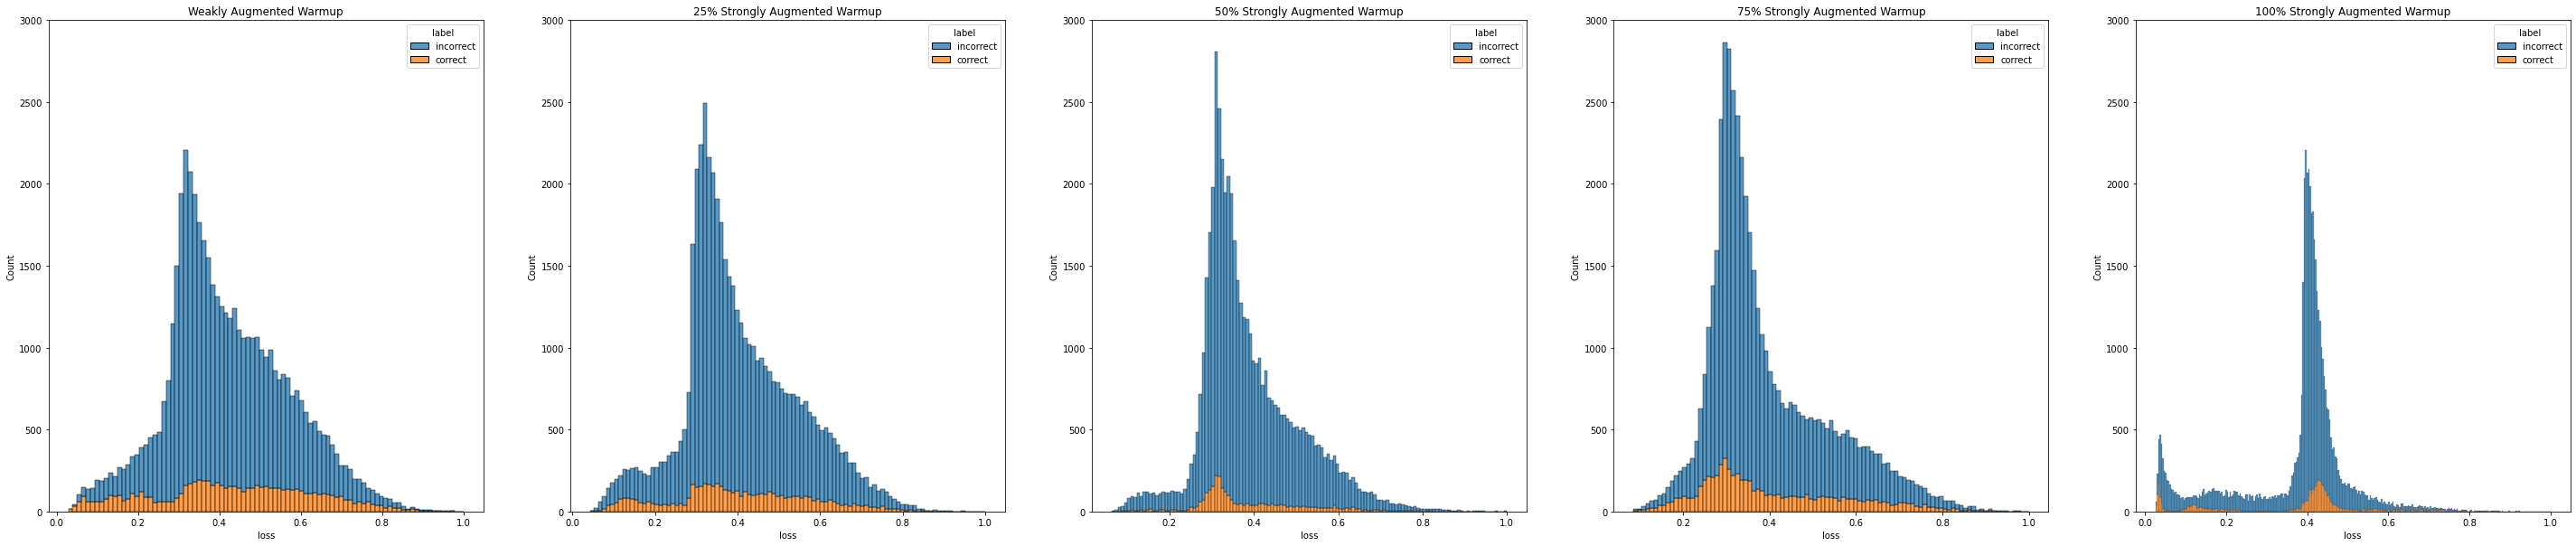

In [84]:
###############################################################
# Noise for correctly versus incorrectly classified
##############################################################

def __get_df(correct, incorrect):
    correct_logits = [x['logits'] for x in correct]
    correct_labels = [x['corrupt'] for x in correct]
    incorrect_logits = [x['logits'] for x in incorrect]
    incorrect_labels = [x['corrupt'] for x in incorrect]

    ce_correct = calc_loss(correct_logits, correct_labels)
    ce_incorrect = calc_loss(incorrect_logits, incorrect_labels)
    df = get_dfs_correct_incorrect(ce_correct, ce_incorrect)
    
    return df
    
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(50,10))
axes[0].set_ylim([0, 3000])
axes[1].set_ylim([0, 3000])
axes[2].set_ylim([0, 3000])
axes[3].set_ylim([0, 3000])
axes[4].set_ylim([0, 3000])

axes[0].set_title("Weakly Augmented Warmup")
axes[1].set_title("25% Strongly Augmented Warmup")
axes[2].set_title("50% Strongly Augmented Warmup")
axes[3].set_title("75% Strongly Augmented Warmup")
axes[4].set_title("100% Strongly Augmented Warmup")


preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.0'
clean_loader, dirty_loader = get_dataloaders()
correct, incorrect = split_by_correct_incorrect(clean_loader, dirty_loader, clean_0, dirty_0)
df = __get_df(correct, incorrect)
sns.histplot(df, x='loss', hue='label', multiple='stack', ax=axes[0])

preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.25'
clean_loader, dirty_loader = get_dataloaders()
correct, incorrect = split_by_correct_incorrect(clean_loader, dirty_loader, clean_25, dirty_25)
df = __get_df(correct, incorrect)
sns.histplot(df, x='loss', hue='label', multiple='stack', ax=axes[1])

preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.50'
clean_loader, dirty_loader = get_dataloaders()
correct, incorrect = split_by_correct_incorrect(clean_loader, dirty_loader, clean_50, dirty_50)
df = __get_df(correct, incorrect)
sns.histplot(df, x='loss', hue='label', multiple='stack', ax=axes[2])

preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.75'
clean_loader, dirty_loader = get_dataloaders()
correct, incorrect = split_by_correct_incorrect(clean_loader, dirty_loader, clean_75, dirty_75)
df = __get_df(correct, incorrect)
sns.histplot(df, x='loss', hue='label', multiple='stack', ax=axes[3])

preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.100'
clean_loader, dirty_loader = get_dataloaders()
correct, incorrect = split_by_correct_incorrect(clean_loader, dirty_loader, clean_100, dirty_100)
df = __get_df(correct, incorrect)
sns.histplot(df, x='loss', hue='label', multiple='stack', ax=axes[4])

/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py
/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py


<AxesSubplot:title={'center':'100% Strongly Augmented Warmup'}, xlabel='loss', ylabel='Count'>

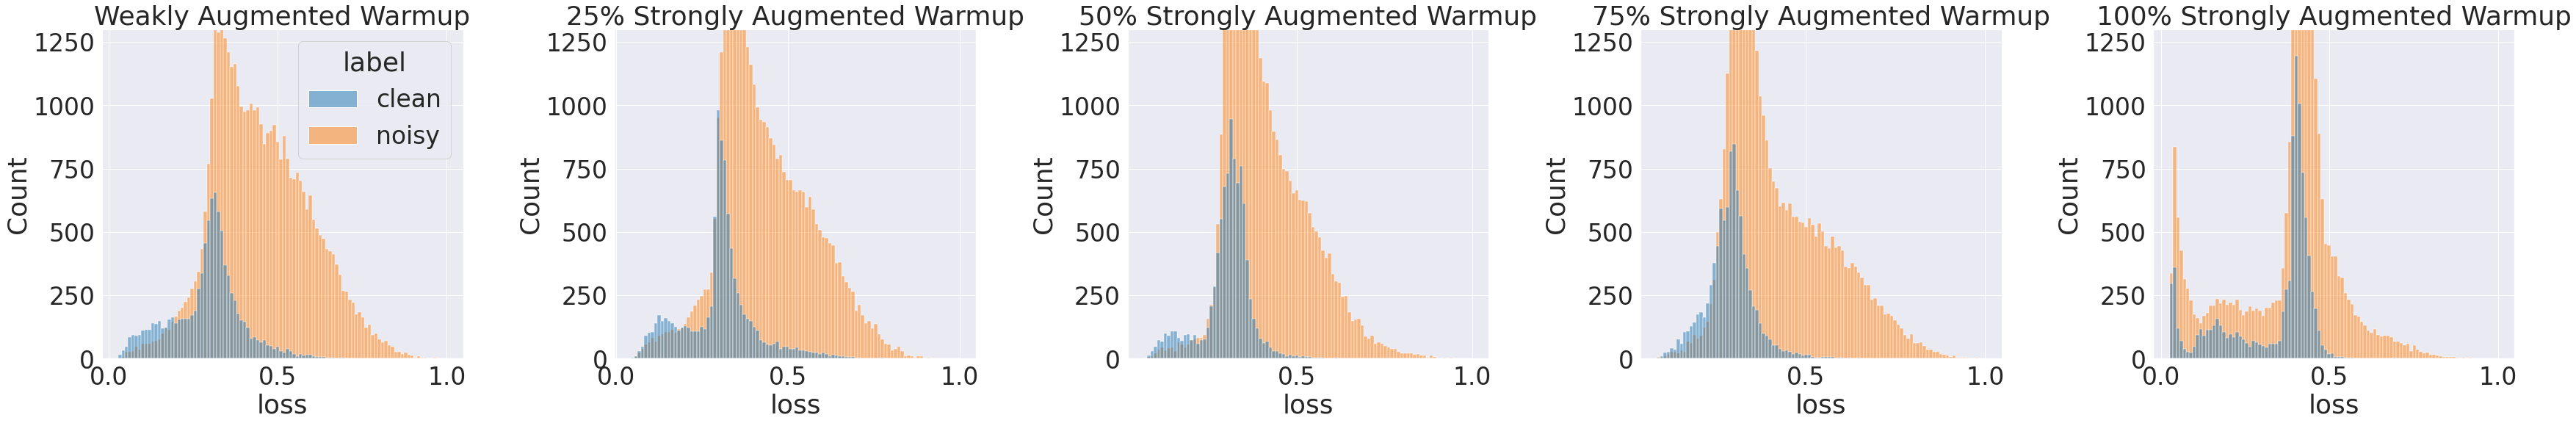

In [31]:

##################################
# Relative to corrupted labels
################################

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(50,10))
fig.tight_layout(pad=3.0)
axes[0].set_ylim([0, 1300])
axes[1].set_ylim([0, 1300])
axes[2].set_ylim([0, 1300])
axes[3].set_ylim([0, 1300])
axes[4].set_ylim([0, 1300])

axes[0].set_title("Weakly Augmented Warmup")
axes[1].set_title("25% Strongly Augmented Warmup")
axes[2].set_title("50% Strongly Augmented Warmup")
axes[3].set_title("75% Strongly Augmented Warmup")
axes[4].set_title("100% Strongly Augmented Warmup")

sns.set(font_scale=3)


preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.0'
clean_loader, dirty_loader = get_dataloaders()
ce_clean = calc_loss(clean_0, clean_loader.dataset.dirty_labels)
ce_dirty = calc_loss(dirty_0, dirty_loader.dataset.dirty_labels)
df = get_dfs(ce_dirty, ce_clean)
sns.histplot(df, x='loss', hue='label', multiple='layer', ax=axes[0], bins=100, palette=sns.color_palette("tab10")[:2])


preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.25'
clean_loader, dirty_loader = get_dataloaders()
ce_clean = calc_loss(clean_25, clean_loader.dataset.dirty_labels)
ce_dirty = calc_loss(dirty_25, dirty_loader.dataset.dirty_labels)
df = get_dfs(ce_dirty, ce_clean)
sns.histplot(df, x='loss', hue='label', multiple='layer', ax=axes[1], bins=100, legend=False, palette=sns.color_palette("tab10")[:2])

preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.50'
clean_loader, dirty_loader = get_dataloaders()
ce_clean = calc_loss(clean_50, clean_loader.dataset.dirty_labels)
ce_dirty = calc_loss(dirty_50, dirty_loader.dataset.dirty_labels)
df = get_dfs(ce_dirty, ce_clean)
sns.histplot(df, x='loss', hue='label', multiple='layer', ax=axes[2], bins=100, legend=False, palette=sns.color_palette("tab10")[:2])


preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.75'
clean_loader, dirty_loader = get_dataloaders()
ce_clean = calc_loss(clean_75, clean_loader.dataset.dirty_labels)
ce_dirty = calc_loss(dirty_75, dirty_loader.dataset.dirty_labels)
df = get_dfs(ce_dirty, ce_clean)
sns.histplot(df, x='loss', hue='label', multiple='layer', ax=axes[3], bins=100, legend=False, palette=sns.color_palette("tab10")[:2])


preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.100'
clean_loader, dirty_loader = get_dataloaders()
ce_clean = calc_loss(clean_100, clean_loader.dataset.dirty_labels)
ce_dirty = calc_loss(dirty_100, dirty_loader.dataset.dirty_labels)
df = get_dfs(ce_dirty, ce_clean)
sns.histplot(df, x='loss', hue='label', multiple='layer', ax=axes[4], bins=100, legend=False, palette=sns.color_palette("tab10")[:2])

In [81]:

preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.100'
clean, dirty = get_dataloaders()

/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py
0.9


/media/work/lgfs/lnl/cifar10/data/cifar-10-batches-py


<AxesSubplot:xlabel='loss', ylabel='Count'>

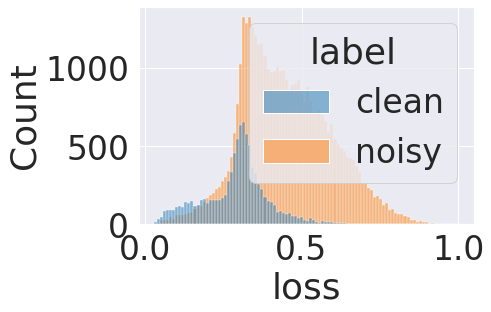

In [29]:

preset='c10.90sym.2xstrong+2xweak.strong_warmup.prob.0'
clean_loader, dirty_loader = get_dataloaders()
ce_clean = calc_loss(clean_0, clean_loader.dataset.dirty_labels)
ce_dirty = calc_loss(dirty_0, dirty_loader.dataset.dirty_labels)
df = get_dfs(ce_dirty, ce_clean)
sns.histplot(df, x='loss', hue='label', multiple='layer', bins=100, palette=sns.color_palette("tab10")[:2])

Text(0.5, 1.0, 'Weakly Augmented Warmup')

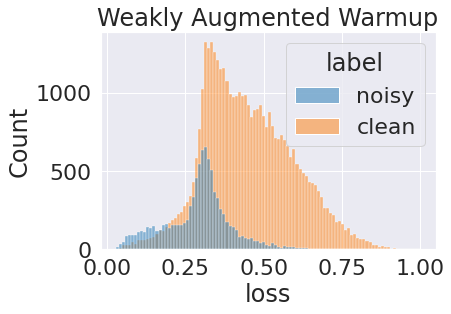

In [25]:

sns.set(font_scale=2)

ax = sns.histplot(df, x='loss', hue='label', multiple='layer', bins=100, palette=sns.color_palette("tab10")[:2])
ax.set_title("Weakly Augmented Warmup")

Text(0.5, 1.0, 'Weakly Augmented Warmup')